# Completeness and Distinctness Issues in Regression

N.B For each DQ issue you are requested to generate 10 different experiments
1 experiment correspond to the generation of a plot/with related tables.
For 1 experiment, the DQ issue assigned to your Group/you must be injected in your data with a different %.
Following, detailed guidelines on which are the expected results for each assigned DQ issue:

Completeness
— consider both Missing Not at Random (MNAR) and Missing Completely at Random (MCAR) missing
value distributions
— 10 experiments with a different distribution of missing values: for example, you can distribute the missing
values uniformly across all columns, or change the percentage of missing values for columns with different
informativeness (changing the default parameter in the data collection). Try to think of a way to simulate
also MNAR distributions!
— For one experiment: varying % of missing values, for example from 5% to 50% (with an increasing step
of 5%) of injected missing values

Distinctness
— 10 experiments with a different number of polluted features: for example, substituting/polluting a different
number of the original features, or adding more and more features
— For one experiment: varying % of distinctness, from very low distinctness (all values constant) to very
high (all unique values)
— You can also try to combine low-distinctness and high-distinctness columns in some experiments


Data Preparation is requested for: Completeness
Select one/more data preparation techniques that we have seen at exercise lectures and implement it/them inside the pipeline.
For Completeness apply Data Imputation.

In [1]:
import random

import numpy as np
from sklearn.datasets import make_regression
from sklearn.impute import SimpleImputer

SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [2]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd '/gdrive/MyDrive/DIQ_Project_I+B/'

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1XMTEJW4jWoTbVZC-NVxBlpEUk4ot_uYE/DIQ_Project_I+B


In [3]:
# DEFAULT PARAMETERS FOR REGRESSION
# X, y = make_dataset_for_regression(n_samples=1000, n_features=3, n_informative=3, n_targets=1, bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023)
# Fixed default parameters
# Can be changed according to the needs of the DQ issue/s to be injected
# If you change parameters: justify why you have changed the default settings inside the report

def make_dataset_for_regression(n_samples, n_features, n_informative,
                                n_targets, bias, effective_rank, tail_strength, noise, seed):
    X, y = make_regression(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=n_informative,
                           n_targets=n_targets,
                           bias=bias,
                           effective_rank=effective_rank,
                           tail_strength=tail_strength,
                           noise=noise,
                           random_state=seed)
    return X, y

In [4]:
# CREATE DATA POLLUTION FUNCTION
# Inject errors/values related to the assigned DQ issue at different (%)
# Combined with dataset.make to inject the assigned DQ issue/s
def pollute_data_MCAR(data, percent_incomplete=0.2, seed=SEED):
    # Set random seed for consistent behavior
    random.seed(seed)

    # Check if the input is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input data must be a Pandas DataFrame.")

    # Generate a mask for incompleteness
    incomplete_mask = [random.random() < percent_incomplete for _ in range(len(data))]

    # MCAR experiment
    # Incompleteness by row
    for index, row in data.iterrows():
        if incomplete_mask[index]:
            # Determine the number of NaN values
            num_nan_values = random.randint(1, len(row))

            # Introduce NaN values
            for i in range(num_nan_values):
                cell_index = random.randint(0, len(row) - 1)
                row.iloc[cell_index] = np.nan

    return data

In [5]:
# DATA ANALYSIS AND EVALUATION
#Metrics: Performance, Distance train-test Performance, Speed
# REGRESSION: Performance (RMSE Root mean squared error), Distance between train & test performances
# (RMSE Root mean squared error), Speed of training
# Creation of plots and tables with the numeric results
# N.B Add also a table/tables with the numeric results inside the report
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, BayesianRidge, Ridge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
import time as time
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


#N.B. ONLY FOR PROJECTS ON DATA TYPES: USE THIS FUNCTION TO ENCODE CATEGORICAL VARIABLES BEFORE STANDARDIZATION
def encoding_categorical_variables(X):
    def encode(original_dataframe, feature_to_encode):
        dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], dummy_na=True)
        res = pd.concat([original_dataframe, dummies], axis=1)
        res = res.drop([feature_to_encode], axis=1)
        return (res)

    categorical_columns = list(X.select_dtypes(include=['bool', 'object']).columns)

    for col in X.columns:
        if col in categorical_columns:
            X = encode(X, col)
    return X


@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=FutureWarning)
def regression(X, y, regression, seed):
    X = StandardScaler().fit_transform(X)
    X = np.nan_to_num(X)
    regressor = Ridge()

    if regression == "LinearRegressor":
        regressor = Ridge()
    elif regression == "BayesianRidge":
        regressor = BayesianRidge()
    elif regression == "GPRegressor":
        regressor = GaussianProcessRegressor()
    elif regression == "SVMRegressor":
        regressor = LinearSVR()
    elif regression == "KNNRegressor":
        regressor = KNeighborsRegressor()
    elif regression == "MLPRegressor":
        regressor = MLPRegressor()

    #print("Training for " + regression + "...")

    start = time.time()

    model_fit = regressor.fit(X=X, y=y)

    cv = ShuffleSplit(n_splits=8, test_size=0.3, random_state=seed)

    model_scores = cross_val_score(model_fit, X, y, cv=cv, scoring="neg_root_mean_squared_error")

    stop = time.time()
    speed = stop - start

    mse_mean = abs(model_scores.mean())

    return {"mean_perf": mse_mean,
            "distance": distance_measurement(X, y, regression, True, seed),
            "speed": speed}


def distance_measurement(X, y, method, regression, seed):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score, mean_squared_error

    X = StandardScaler().fit_transform(X)
    X = np.nan_to_num(X)

    N = 8
    distances_train_test = np.zeros(N)
    for i in range(0, N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed + i)

        model = DecisionTreeClassifier()

        if method == "DecisionTree":
            model = DecisionTreeClassifier()
        elif method == "LogisticRegression":
            model = LogisticRegression()
        elif method == "KNN":
            model = KNeighborsClassifier()
        elif method == "RandomForest":
            model = RandomForestClassifier()
        elif method == "AdaBoost":
            model = AdaBoostClassifier()
        elif method == "MLP":
            model = MLPClassifier()
        elif method == "LinearRegressor":
            model = Ridge()
        elif method == "BayesianRidge":
            model = BayesianRidge()
        elif method == "GPRegressor":
            model = GaussianProcessRegressor()
        elif method == "SVMRegressor":
            model = LinearSVR()
        elif method == "KNNRegressor":
            model = KNeighborsRegressor()
        elif method == "MLPRegressor":
            model = MLPRegressor()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_fit = model.predict(X_train)

        if regression:
            mse_pred = abs(mean_squared_error(y_test, y_pred, squared=False))
            mse_fit = abs(mean_squared_error(y_train, y_fit, squared=False))

            distances_train_test[i] = mse_pred - mse_fit
        else:
            weighted_f1_pred = f1_score(y_test, y_pred, average='weighted')
            weighted_f1_fit = f1_score(y_train, y_fit, average='weighted')

            distances_train_test[i] = weighted_f1_fit - weighted_f1_pred

    return distances_train_test.mean()

In [6]:
your_path = "Plot/Completeness_Trials/MCAR/"

def mean(results_all):
    list_mean = []
    for res in results_all:
        list_mean.append(res["mean_perf"])
    return list_mean


def distance(results_all):
    list_over = []
    for res in results_all:
        list_over.append(res["distance"])
    return list_over


def speed(results_all):
    list_speed = []
    for res in results_all:
        list_speed.append(res["speed"])
    return list_speed


def generateFigurePerformance(x_axis, xlabel, results_all, title, legend, score):
    plt.title(title)
    for i in range(0, len(results_all)):
        mean_perf = mean(results_all[i])

        plt.plot(x_axis, mean_perf, marker='o', label=legend[i], markersize=3)

    plt.xlabel(xlabel)
    plt.ylabel(score)
    plt.legend()
    #plt.ylim(0.1, 2)  # if you want to fix a limit for the y_axis
    plt.savefig(your_path + title + ".pdf", bbox_inches='tight')  # if you want to save the figure
    plt.show()


def generateFigureDistance(x_axis, xlabel, results_all, title, legend, score):
    plt.title(title)
    for i in range(0, len(results_all)):
        distance_perf = distance(results_all[i])

        plt.plot(x_axis, distance_perf, marker='o', label=legend[i], markersize=3)

    plt.xlabel(xlabel)
    plt.ylabel(score)
    plt.legend()
    #plt.ylim(0.1, 2) # if you want to fix a limit for the y_axis
    plt.savefig(your_path + title + ".pdf", bbox_inches='tight')  # if you want to save the figure
    plt.show()


def generateFigureSpeed(x_axis, xlabel, results_all, title, legend, score):
    plt.title(title)
    for i in range(0, len(results_all)):
        speed_perf = speed(results_all[i])

        plt.plot(x_axis, speed_perf, marker='o', label=legend[i], markersize=3)

    plt.xlabel(xlabel)
    plt.ylabel(score)
    plt.legend()
    #plt.ylim(0.1, 2)  # if you want to fix a limit for the y_axis
    plt.savefig(your_path + title + ".pdf", bbox_inches='tight')  # if you want to save the figure
    plt.show()


def plot(x_axis_values, x_label, results, title, algorithms, plot_type):
    title = str(title)

    if plot_type == "performance":
        if algorithms[0] == "LinearRegressor":
            generateFigurePerformance(x_axis_values, x_label, results, title, algorithms, "RMSE")
        else:
            generateFigurePerformance(x_axis_values, x_label, results, title, algorithms, "silhouette")

    elif plot_type == "distance train-test":  # only for classification & regression
        generateFigureDistance(x_axis_values, x_label, results, title, algorithms, "RMSE_test - RMSE_train")

    else:
        generateFigureSpeed(x_axis_values, x_label, results, title, algorithms, "speed")

# Example and recap of the main phases to perform

In [7]:
import pandas as pd

REGRESSION_ALGORITHMS = ["LinearRegressor", "BayesianRidge", "GPRegressor", "SVMRegressor", "KNNRegressor",
                         "MLPRegressor"]

SEED = 2023

if __name__ == '__main__':
    print("Main ...")

    # A: DATA COLLECTION
    #X, y = make_dataset_for_regression(n_samples=1000, n_features=3, n_informative=3, n_targets=1, bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023) - default parameters
    X, y = make_dataset_for_regression(n_samples=1000, n_features=3, n_informative=3, n_targets=1, bias=0.0,
                                       effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023)
    X_df = pd.DataFrame(X)

    # B: DATA POLLUTION
    # YOUR POLLUTION FUNCTION (on the generated datasets)
    # Can insert DQ issues with certain percentages (can create a mask of T and F values of the same length of the dataframe X in order to use the loc function and localize the rows in which to perform some actions)
    # This mask can be generated with the random function of python (random seed) used to match the dataframe and substitute the value
    pollute_data_MCAR(X_df)

    # D: DATA ANALYSIS
    #for algorithm in CLASSIFICATION/REGRESSION/CLUSTERING_ALGORITHMS:
    #results_2_analysis = classification(X, y, algorithm, SEED):
    #results_2_analysis = regression(X, y, algorithm, SEED)
    #results_2_analysis = clustering(X, algorithm, n_clusters, SEED)

    # C: DATA PREPARATION (IF REQUESTED, IT DEPENDS ON THE DQ ISSUE)
    # YOUR DATA PREPARATION FUNCTION (to apply on the generated datasets)
    # For Completeness apply Data Imputation in the Data Preparation phase - try different imputation techniques (ffill, bfill, mean, median, ML methods)

    # D: DATA ANALYSIS ON THE CLEANED DATASETS (re-compute the data analysis evaluation on prepared dataset)
    #for algorithm in CLASSIFICATION/REGRESSION/CLUSTERING_ALGORITHMS:
    #results_2_analysis = classification(X, y, algorithm, SEED):
    #results_2_analysis = regression(X, y, algorithm, SEED)
    #results_2_analysis = clustering(X, algorithm, n_clusters, SEED)

    # E: PLOT RESULTS
    # RESULTS EVALUATION
    # ADD TABLES WITH THE RESULTS FOR THE REPORT!


Main ...


In [ ]:
# REGRESSION EXAMPLE - an example of one experiment, but we have to generate 10 different experiments (can change a parameter between experiments, with different setup of the data pollution function)
# (in this toy example, I simply created 10 datasets with respectively 1000,1001,1002,1003,1004,1005,1006,1007,1008,1009 number of samples
# and I generated the three plots for the evaluation of the results)
results_for_each_algorithm = []
for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    results_single_algorithm = []
    for i in range(0,
                   10):  # SECOND CYCLE ON THE NUMBER OF POLLUTED DATASET THAT YOU WANT TO CREATE WITH DIFFERENT % OF POLLUTION
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(n_samples=1000 + i * 1000, n_features=3, n_informative=3, n_targets=1,
                                           bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023)
        X = pd.DataFrame(X)
        pollute_data_MCAR(X)

        # DATA ANALYSIS
        results_1_analysis = regression(X, y, algorithm, SEED)
        results_single_algorithm.append(results_1_analysis)

    results_for_each_algorithm.append(results_single_algorithm)

In [ ]:
# RESULTS EVALUATION
# EXAMPLE FOR USING THE SCRIPTS TO PLOT THE RESULTS - x_axis for the data quality issue, while the y_axis is the performance measure
# Injecting a high amount of issues in the dataset, the model will learn on that errors, so it will have a performance value really far from the one of the test set
plot(x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009], x_label="Number of samples",
     results=results_for_each_algorithm, title="Plot trial regression perf", algorithms=REGRESSION_ALGORITHMS,
     plot_type="performance")
plot(x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009], x_label="Number of samples",
     results=results_for_each_algorithm, title="Plot trial regression dist", algorithms=REGRESSION_ALGORITHMS,
     plot_type="distance train-test")
plot(x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009], x_label="Number of samples",
     results=results_for_each_algorithm, title="Plot trial regression speed", algorithms=REGRESSION_ALGORITHMS,
     plot_type="speed")

In [ ]:
# C: DATA PREPARATION (IF REQUESTED, IT DEPENDS ON THE DQ ISSUE)
# YOUR DATA PREPARATION FUNCTION (to apply on the generated datasets)
# For Completeness apply Data Imputation in the Data Preparation phase - try different imputation techniques (ffill, bfill, mean, median, ML methods)
SI = SimpleImputer(missing_values=np.NaN, strategy="median")  #as fillna - mean
# Define another dataset in which we use SI to impute the null values

In [ ]:
results_for_each_algorithm_on_cleaned_data = []
for algorithm in REGRESSION_ALGORITHMS:  # FIRST CYCLE ON THE ALGORITHMS
    results_single_algorithm_on_cleaned_data = []
    for i in range(0,
                   10):  # SECOND CYCLE ON THE NUMBER OF POLLUTED DATASET THAT YOU WANT TO CREATE WITH DIFFERENT % OF POLLUTION
        # DATA COLLECTION - creating 10 datasets with an increase in the samples
        X, y = make_dataset_for_regression(n_samples=1000 + i, n_features=3, n_informative=3, n_targets=1, bias=0.0,
                                           effective_rank=None, tail_strength=0.5, noise=0.0, seed=2023)
        X = pd.DataFrame(X)
        pollute_data_MCAR(X)
        X_cleaned = SI.fit_transform(X)

        # DATA ANALYSIS
        results_1_analysis = regression(X_cleaned, y, algorithm, SEED)
        results_single_algorithm_on_cleaned_data.append(results_1_analysis)

    results_for_each_algorithm_on_cleaned_data.append(results_single_algorithm_on_cleaned_data)

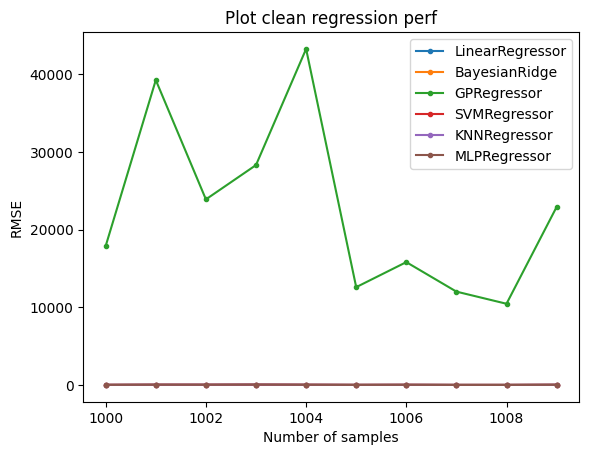

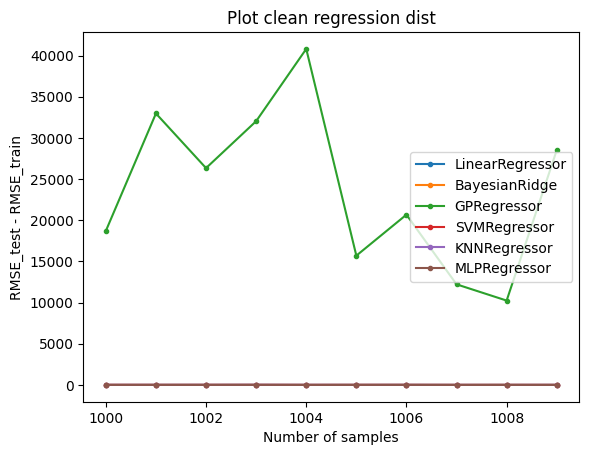

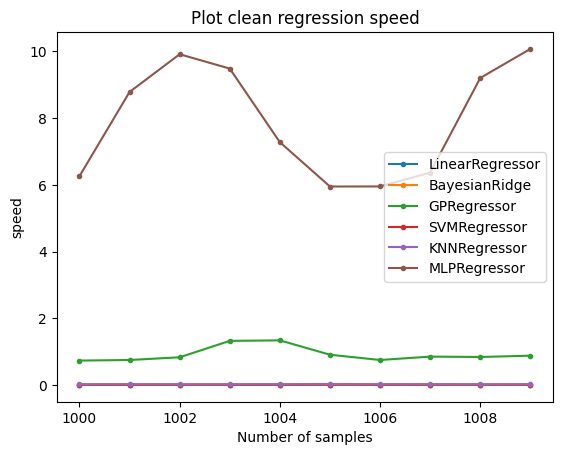

In [ ]:
plot(x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009], x_label="Number of samples",
     results=results_for_each_algorithm_on_cleaned_data, title="Plot clean regression perf",
     algorithms=REGRESSION_ALGORITHMS, plot_type="performance")
plot(x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009], x_label="Number of samples",
     results=results_for_each_algorithm_on_cleaned_data, title="Plot clean regression dist",
     algorithms=REGRESSION_ALGORITHMS, plot_type="distance train-test")
plot(x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009], x_label="Number of samples",
     results=results_for_each_algorithm_on_cleaned_data, title="Plot clean regression speed",
     algorithms=REGRESSION_ALGORITHMS, plot_type="speed")

In [ ]:
import matplotlib.pyplot as plt

your_path = "Plot/Completeness_Trials/MCAR/"


def mean(results_all):
    list_mean = []
    for res in results_all:
        list_mean.append(res["mean_perf"])
    return list_mean


def distance(results_all):
    list_over = []
    for res in results_all:
        list_over.append(res["distance"])
    return list_over


def speed(results_all):
    list_speed = []
    for res in results_all:
        list_speed.append(res["speed"])
    return list_speed


def generateFigurePerformanceZoomIn(zoom, x_axis, xlabel, results_all, title, legend, score):
    plt.title(title)
    for i in range(0, len(results_all)):
        mean_perf = mean(results_all[i])

        plt.plot(x_axis, mean_perf, marker='o', label=legend[i], markersize=3)

    plt.xlabel(xlabel)
    plt.ylabel(score)
    plt.legend()

    #Setting the ylim we zoom in on the RMSE of the regressors that seem to have null error otherwise
    plt.ylim(0, zoom)

    #plt.ylim(0.1, 2)  # if you want to fix a limit for the y_axis
    plt.savefig(your_path + title + ".pdf", bbox_inches='tight')  # if you want to save the figure
    plt.show()


def generateFigureDistanceZoomIn(zoom, x_axis, xlabel, results_all, title, legend, score):
    plt.title(title)
    for i in range(0, len(results_all)):
        distance_perf = distance(results_all[i])

        plt.plot(x_axis, distance_perf, marker='o', label=legend[i], markersize=3)

    plt.xlabel(xlabel)
    plt.ylabel(score)
    plt.legend()
    plt.ylim(0, zoom)
    #plt.ylim(0.1, 2) # if you want to fix a limit for the y_axis
    plt.savefig(your_path + title + ".pdf", bbox_inches='tight')  # if you want to save the figure
    plt.show()


def generateFigureSpeedZoomIn(zoom, x_axis, xlabel, results_all, title, legend, score):
    plt.title(title)
    for i in range(0, len(results_all)):
        speed_perf = speed(results_all[i])

        plt.plot(x_axis, speed_perf, marker='o', label=legend[i], markersize=3)

    plt.xlabel(xlabel)
    plt.ylabel(score)
    plt.legend()
    plt.ylim(0, zoom)
    #plt.ylim(0.1, 2)  # if you want to fix a limit for the y_axis
    plt.savefig(your_path + title + ".pdf", bbox_inches='tight')  # if you want to save the figure
    plt.show()


def plotZoomIn(zoom, x_axis_values, x_label, results, title, algorithms, plot_type):
    title = str(title)

    if plot_type == "performance":
        if algorithms[0] == "LinearRegressor":
            generateFigurePerformanceZoomIn(zoom, x_axis_values, x_label, results, title, algorithms, "RMSE")
        else:
            generateFigurePerformanceZoomIn(zoom, x_axis_values, x_label, results, title, algorithms, "silhouette")

    elif plot_type == "distance train-test":  # only for classification & regression
        generateFigureDistanceZoomIn(zoom, x_axis_values, x_label, results, title, algorithms, "RMSE_test - RMSE_train")

    else:
        generateFigureSpeedZoomIn(zoom, x_axis_values, x_label, results, title, algorithms, "speed")

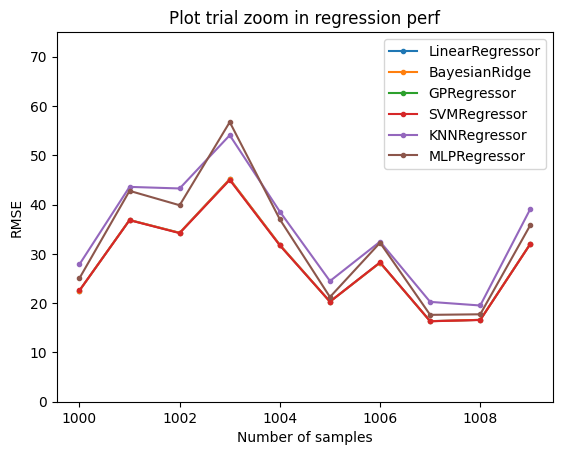

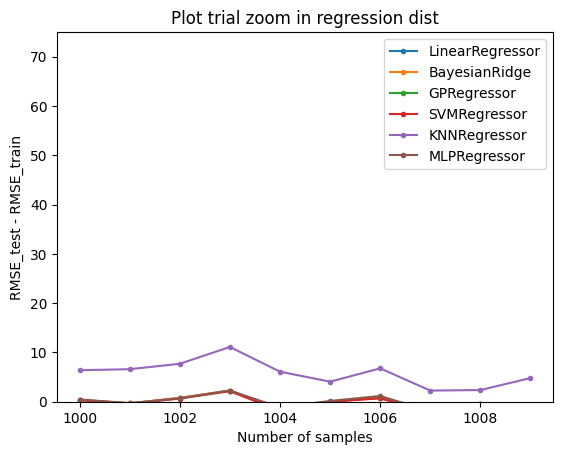

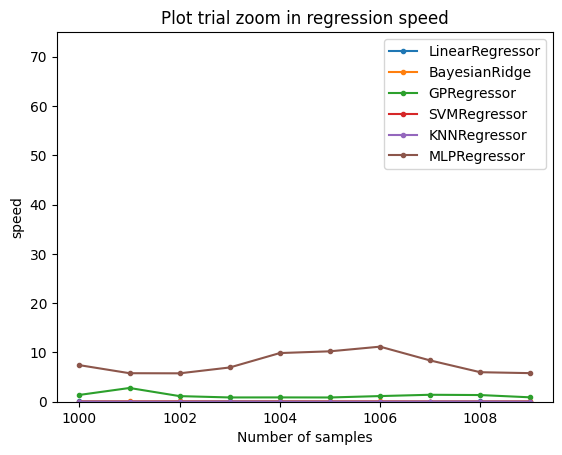

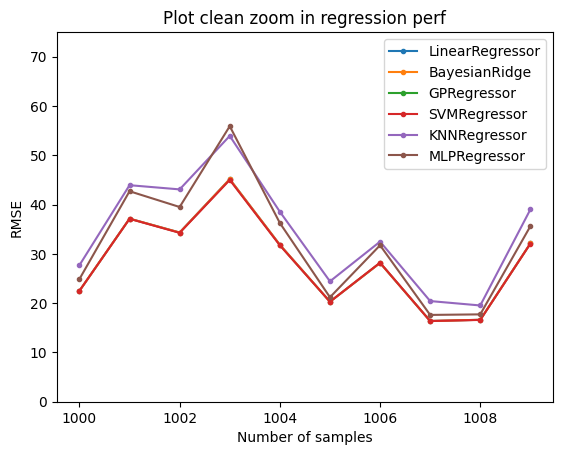

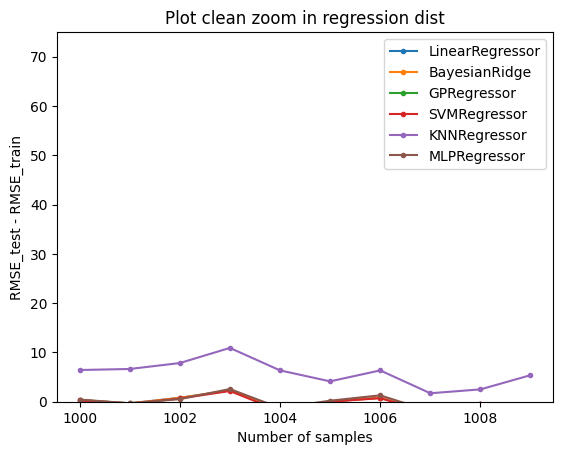

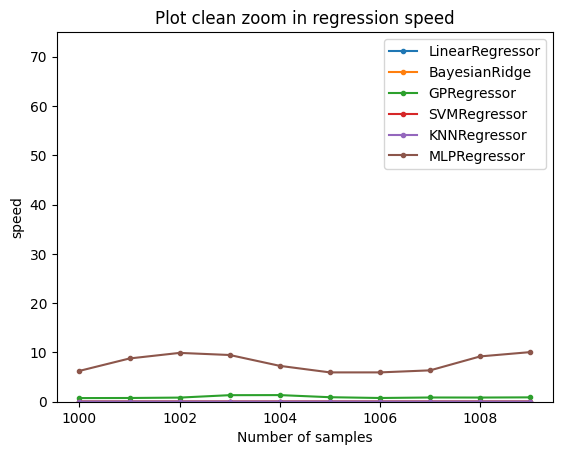

In [ ]:
# RESULTS EVALUATION
# EXAMPLE FOR USING THE SCRIPTS TO PLOT THE RESULTS - x_axis for the data quality issue, while the y_axis is the performance measure
# Injecting a high amount of issues in the dataset, the model will learn on that errors, so it will have a performance value really far from the one of the test set
plotZoomIn(zoom=np.max(results_for_each_algorithm),
           x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009], x_label="Number of samples",
           results=results_for_each_algorithm, title="Plot trial zoom in regression perf",
           algorithms=REGRESSION_ALGORITHMS, plot_type="performance")
plotZoomIn(zoom=75, x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009],
           x_label="Number of samples", results=results_for_each_algorithm, title="Plot trial zoom in regression dist",
           algorithms=REGRESSION_ALGORITHMS, plot_type="distance train-test")
plotZoomIn(zoom=75, x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009],
           x_label="Number of samples", results=results_for_each_algorithm, title="Plot trial zoom in regression speed",
           algorithms=REGRESSION_ALGORITHMS, plot_type="speed")

plotZoomIn(zoom=75, x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009],
           x_label="Number of samples", results=results_for_each_algorithm_on_cleaned_data,
           title="Plot clean zoom in regression perf", algorithms=REGRESSION_ALGORITHMS, plot_type="performance")
plotZoomIn(zoom=75, x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009],
           x_label="Number of samples", results=results_for_each_algorithm_on_cleaned_data,
           title="Plot clean zoom in regression dist", algorithms=REGRESSION_ALGORITHMS,
           plot_type="distance train-test")
plotZoomIn(zoom=75, x_axis_values=[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009],
           x_label="Number of samples", results=results_for_each_algorithm_on_cleaned_data,
           title="Plot clean zoom in regression speed", algorithms=REGRESSION_ALGORITHMS, plot_type="speed")